# Algoritmo de Grover con PennyLane
En este tutorial, vamos a implementar una búsqueda de una cadena de n bits utilizando un circuito cuántico basado en el algoritmo de Grover.

El algoritmo se puede dividir en los siguientes pasos:

1. Preparar el estado inicial
2. Implementar el oráculo
3. Aplicar el operador de difusión de Grover
4. Repetir los pasos 2 y 3 aproximadamente $ \frac{\pi}{4} \sqrt{N} $ veces
5. Medir los qubits

Vamos a importar las librerías habituales de PennyLane y Numpy para cargar las funciones necesarias:

In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

## Preparando el estado inicial
Esto puede lograrse aplicando Hadamard en todos los estados cuánticos.

In [4]:
NUM_QUBITS = 2
dev = qml.device("default.qubit", wires=NUM_QUBITS)
wires = list(range(NUM_QUBITS))


def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)


@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state")
    equal_superposition(wires)
    qml.Snapshot("After applying the Hadamard gates")
    return qml.probs(wires=wires)  # Probability of finding a computational basis state on the wires


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Initial state: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After applying the Hadamard gates: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


La celda anterior se puede explicar de la siguiente forma:

1. **Definición de parámetros y dispositivo cuántico**  
   - `NUM_QUBITS = 2`: Se define que el circuito tendrá 2 qubits.
   - `dev = qml.device("default.qubit", wires=NUM_QUBITS)`: Se crea un simulador cuántico con 2 qubits usando PennyLane.
   - `wires = list(range(NUM_QUBITS))`: Se crea una lista con los índices de los qubits, es decir, `[0, 1]`.

2. **Función de superposición**  
   - `equal_superposition(wires)`: Esta función aplica la compuerta Hadamard a cada qubit, lo que coloca a todos los qubits en una superposición uniforme de todos los estados posibles.

3. **Definición del circuito cuántico**  
   - `@qml.qnode(dev)`: Decorador que indica que la función `circuit` es un circuito cuántico que se ejecutará en el dispositivo definido.
   - Dentro de `circuit()`:
     - `qml.Snapshot("Initial state")`: Guarda el estado inicial del sistema.
     - `equal_superposition(wires)`: Aplica la superposición a todos los qubits.
     - `qml.Snapshot("After applying the Hadamard gates")`: Guarda el estado después de aplicar las compuertas Hadamard.
     - `return qml.probs(wires=wires)`: Devuelve las probabilidades de medir cada estado posible de los qubits.

4. **Ejecución y visualización de resultados**  
   - `results = qml.snapshots(circuit)()`: Ejecuta el circuito y obtiene los estados guardados en los snapshots.
   - El bucle `for` imprime el nombre del snapshot y el resultado correspondiente.

**Resumen:**  
Este fragmento prepara un circuito cuántico de 2 qubits, aplica una superposición uniforme y muestra las probabilidades de los estados antes y después de aplicar las compuertas Hadamard, usando snapshots para observar el estado del sistema en diferentes etapas.

A continuación usemos un plot de barras para visualizar las probabilidades de los estados de los qubits antes y después de aplicar las compuertas Hadamard.

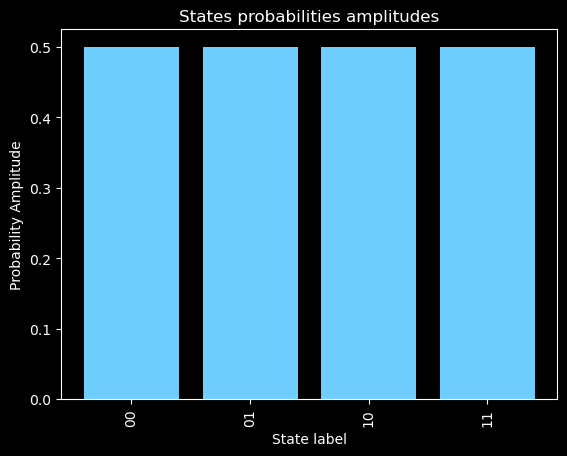

In [5]:
y = np.real(results["After applying the Hadamard gates"])
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, y, color = "#70CEFF")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")
plt.show()

Como se espera, los estados están perfectamente distribuidos entre los 4 estados posibles de 2 qubits, es decir, $|00\rangle$, $|01\rangle$, $|10\rangle$ y $|11\rangle$.

## El oráculo y el difusor
Veamos a continuación cómo nuestro circuito sigue creciendo

Initial state |00>: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After flipping it: [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
execution_results: [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]


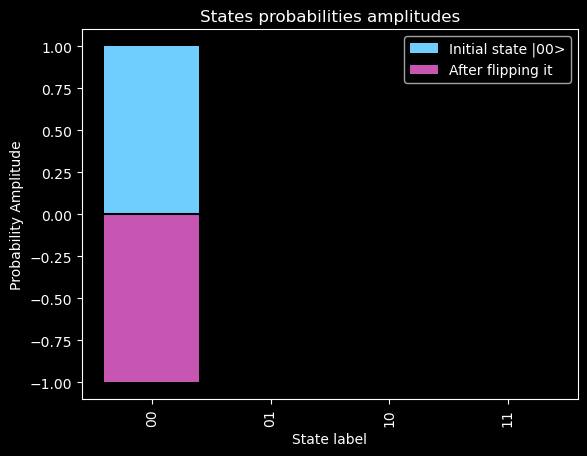

In [8]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state |00>")
    # Flipping the marked state
    qml.FlipSign([0, 0], wires=wires)
    qml.Snapshot("After flipping it")
    return qml.state()

results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

y1 = np.real(results["Initial state |00>"])
y2 = np.real(results["After flipping it"])

bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, y1, color = "#70CEFF")
plt.bar(bit_strings, y2, color = "#C756B2")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")

plt.legend(["Initial state |00>", "After flipping it"])
plt.axhline(y=0.0, color="k", linestyle="-")
plt.show()

La celda anterior muestra cómo funciona el oráculo en el algoritmo de Grover utilizando PennyLane. A continuación se explica cada parte:

1. **Definición del dispositivo y circuito**  
  - Se crea un nuevo dispositivo cuántico con el mismo número de qubits (`NUM_QUBITS = 2`).
  - Se define un circuito cuántico donde:
    - Se toma un snapshot del estado inicial $|00\rangle$.
    - Se aplica la operación `qml.FlipSign([0, 0], wires=wires)`, que invierte el signo de la amplitud del estado marcado $|00\rangle$ (el oráculo).
    - Se toma otro snapshot después de aplicar el oráculo.
    - Se retorna el estado cuántico completo.

2. **Ejecución y obtención de resultados**  
  - Se ejecuta el circuito y se obtienen los estados guardados en los snapshots.
  - Se imprimen los resultados de cada snapshot.

3. **Visualización**  
  - Se grafican las amplitudes de probabilidad de los estados antes y después de aplicar el oráculo.
  - El estado $|00\rangle$ cambia su amplitud de $+1$ a $-1$, mientras que los demás permanecen en $0$.
  - Se utiliza una gráfica de barras para comparar ambos estados y se añade una línea horizontal en $y=0$ para visualizar el cambio de signo.

**Resumen:**  
Esta celda ilustra cómo el oráculo identifica el estado marcado invirtiendo su amplitud, un paso fundamental en el algoritmo de Grover.

Now, let us prepare the Oracle and inspect its action in the circuit.

In [9]:
omega = np.zeros(NUM_QUBITS)

def oracle(wires, omega):
    qml.FlipSign(omega, wires=wires)

dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Before querying the Oracle")

    oracle(wires, omega)
    qml.Snapshot("After querying the Oracle")

    return qml.probs(wires=wires)

results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Before querying the Oracle: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
After querying the Oracle: [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


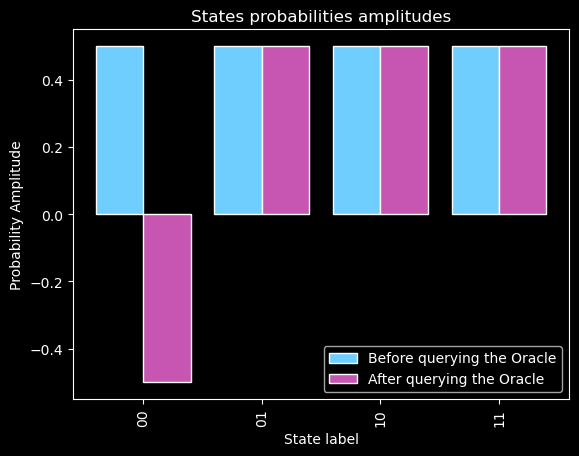

In [10]:
y1 = np.real(results["Before querying the Oracle"])
y2 = np.real(results["After querying the Oracle"])

bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y1))]

bar_width = 0.4

rect_1 = np.arange(0, len(y1))
rect_2 = [x + bar_width for x in rect_1]

plt.bar(
    rect_1,
    y1,
    width=bar_width,
    edgecolor="white",
    color = "#70CEFF",
    label="Before querying the Oracle",
)
plt.bar(
    rect_2,
    y2,
    width=bar_width,
    edgecolor="white",
    color = "#C756B2",
    label="After querying the Oracle",
)

plt.xticks(rect_1 + 0.2, bit_strings, rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")

plt.legend()
plt.show()

La celda anterior muestra cómo actúa el oráculo dentro del algoritmo de Grover. Primero, se prepara una superposición uniforme de todos los estados posibles aplicando compuertas Hadamard a cada qubit. Luego, se aplica el oráculo, que invierte el signo de la amplitud del estado marcado (en este caso, el estado $|00\rangle$). 

Se toman snapshots antes y después de aplicar el oráculo para comparar las probabilidades de los diferentes estados. Finalmente, se grafican ambas distribuciones de probabilidad, permitiendo visualizar cómo el oráculo afecta únicamente al estado marcado, invirtiendo su amplitud, mientras que los demás permanecen sin cambios. Esto es un paso fundamental en el algoritmo de Grover, ya que permite identificar el estado buscado.

In [11]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)


def diffusion_operator(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)
        qml.PauliZ(wires=wire)
    qml.ctrl(qml.PauliZ, 0)(wires=1)
    for wire in wires:
        qml.Hadamard(wires=wire)


@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Uniform superposition |s>")

    oracle(wires, omega)
    qml.Snapshot("State marked by Oracle")
    diffusion_operator(wires)

    qml.Snapshot("Amplitude after diffusion")
    return qml.probs(wires=wires)


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Uniform superposition |s>: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
State marked by Oracle: [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
Amplitude after diffusion: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
execution_results: [1. 0. 0. 0.]


## Búsqueda en una lista más grande

En la celda correspondiente a la búsqueda con 5 qubits, el oráculo está configurado para marcar dos estados cuánticos: el estado $|00000\rangle$ (todos los qubits en 0) y el estado $|11111\rangle$ (todos los qubits en 1). Esto se observa en la variable `omega`, que contiene dos arreglos: uno de ceros y otro de unos.

Por lo tanto, el algoritmo de Grover en esa celda está buscando los estados $|00000\rangle$ y $|11111\rangle$ dentro del espacio de $2^5 = 32$ posibles estados.

In [12]:
NUM_QUBITS = 5

omega = np.array([np.zeros(NUM_QUBITS), np.ones(NUM_QUBITS)])

M = len(omega)
N = 2**NUM_QUBITS
wires = list(range(NUM_QUBITS))

dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    iterations = int(np.round(np.sqrt(N / M) * np.pi / 4))

    # Initial state preparation
    equal_superposition(wires)

    # Grover's iterator
    for _ in range(iterations):
        for omg in omega:
            oracle(wires, omg)
        qml.templates.GroverOperator(wires)

    return qml.probs(wires=wires)


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

execution_results: [0.48065948 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.48065948]


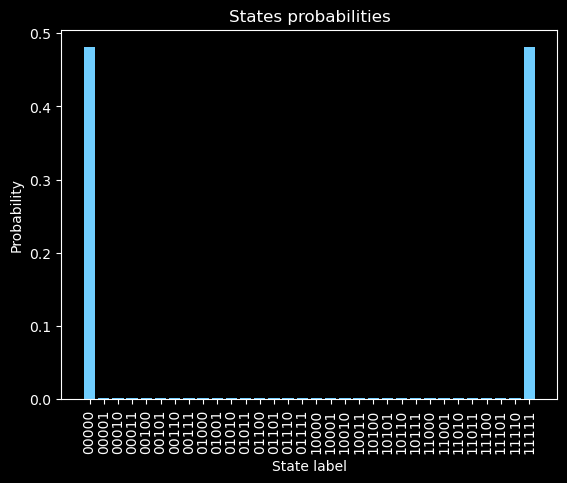

In [13]:
y = results["execution_results"]
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, results["execution_results"], color = "#70CEFF")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability")
plt.title("States probabilities")

plt.show()